In [1]:
# Import libraries

import pandas as pd
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import importlib
# import meterUncertainty
import itertools
from scipy import odr
import lxml
# importlib.reload(meterUncertainty)

In [2]:
# Import data, basic data cleanup

satelliteResults = pd.read_csv('/Users/evansherwin/PycharmProjects/SatelliteTesting/Data/matchedDF_Satellites_230118e.csv')
satelliteResults['Estimate (KGH) num'] = satelliteResults['FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce')
satelliteResults['Error num'] = (satelliteResults['Estimate (KGH) num'] - satelliteResults['cr_kgh_CH4_mean300'])*100/satelliteResults['cr_kgh_CH4_mean300']
satelliteResults['Wind speed est num'] = satelliteResults['WindSpeed'].apply(pd.to_numeric, errors='coerce')
# satelliteResults['Estimate in situ wind (KGH) num'] = satelliteResults['ISWind FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce')
# satelliteResults['Error in situ wind num'] = satelliteResults['Error in situ wind'].apply(pd.to_numeric, errors='coerce')*100
# satelliteResults.head()
satelliteResults

,Unnamed: 0,level_0,index,PerformerExperimentID,FacilityID,EquipmentUnitID,DateOfSurvey,Operator_Timestamp,StartTime,EndTime,...,cr_kgh_CH4_upper300,cr_kgh_CH4_mean600,cr_kgh_CH4_lower600,cr_kgh_CH4_upper600,cr_kgh_CH4_mean900,cr_kgh_CH4_lower900,cr_kgh_CH4_upper900,Estimate (KGH) num,Error num,Wind speed est num
0,0.0,1672.0,NaN,1.0,1.0,1.0,NaN,2021-10-16 17:26:40+00:00,NaN,NaN,...,1779.495469,1697.119999,1553.816116,1864.022376,1686.851597,1495.228521,1888.052860,1382.0,-17.140810,3.720000
1,1.0,1724.0,NaN,1.0,1.0,1.0,NaN,2021-10-16 17:26:40+00:00,NaN,NaN,...,1773.164358,1694.356406,1544.091848,1826.400549,1664.343187,1493.249938,1876.415357,1534.0,-8.209268,4.270000
2,2.0,1673.0,NaN,2.0,1.0,1.0,NaN,2021-10-24 17:35:19+00:00,NaN,NaN,...,4484.857808,4238.145503,4002.961571,4487.774311,4216.022530,3990.286746,4465.095937,3848.0,-8.889579,2.010000
3,3.0,1725.0,NaN,2.0,1.0,1.0,NaN,2021-10-24 17:35:19+00:00,NaN,NaN,...,4498.291022,4229.551134,4002.861846,4456.075687,4210.302115,3989.505816,4441.528761,4408.0,4.051805,2.490000
4,4.0,1674.0,NaN,3.0,1.0,1.0,NaN,2021-10-25 17:24:37+00:00,NaN,NaN,...,208.631220,198.448135,187.738648,210.096073,147.709664,140.086366,156.236479,223.0,12.992303,5.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,83.0,1775.0,NaN,48.0,NaN,NaN,NaN,2021-11-03 18:25:01+00:00,NaN,NaN,...,1460.175444,1400.864644,1319.854699,1477.249663,1265.086694,1201.493490,1331.607519,0.0,-100.000000,0.000000
94,84.0,1690.0,NaN,16.0,NaN,NaN,NaN,2021-10-23 18:40:53+00:00,NaN,NaN,...,4180.538944,4012.906091,3814.234600,4247.224919,4011.045702,3808.841204,4229.398984,4069.0,2.936855,3.771273
95,85.0,1705.0,NaN,30.0,1.0,1.0,NaN,2021-10-23 18:40:53+00:00,NaN,NaN,...,4187.135793,4020.250944,3808.753978,4260.245988,4018.420708,3829.280479,4251.379848,1282.0,-67.603800,2.900000
96,86.0,1742.0,NaN,16.0,NaN,NaN,NaN,2021-10-23 18:40:53+00:00,NaN,NaN,...,4189.653403,4011.644618,3806.757670,4224.039595,4009.838172,3797.734234,4217.441557,4790.0,21.265665,4.673417


In [7]:
# np.unique(satelliteResults['Team']), np.unique(satelliteResults['Team'])[[2, 3, 4, 1, 0]] # Reorder team names to match factor levels
# np.unique(satelliteResults['Satellite']), np.unique(satelliteResults['Satellite'])[[3, 1, 2, 4, 0]]


(array(['GHGSat C2', 'Landsat 8', 'PRISMA', 'Sentinel-2', 'WV3'],
       dtype=object),
 array(['Sentinel-2', 'Landsat 8', 'PRISMA', 'WV3', 'GHGSat C2'],
       dtype=object))

In [3]:
# Reorder satellite and team factor levels

satelliteNames = np.unique(satelliteResults['Satellite'])[[3, 1, 2, 4, 0]] # [[0, 2, 3, 1, 4]] # Reorder satellite names to match factor levels
numSatellites = satelliteNames.size
satelliteResults['SatelliteNum'] = pd.factorize(satelliteResults['Satellite'])[0] + 1
teamNames = np.unique(satelliteResults['Team'])[[2, 3, 4, 1, 0]] # Reorder team names to match factor levels # [[0, 4, 2, 1, 3]] # Reorder team names to match factor levels
numTeams = teamNames.size
satelliteResults['teamNum'] = pd.factorize(satelliteResults['Team'])[0] + 1


In [4]:
# Generate errorbars

yCImult = 1 # 1 #1.96 # Multiplier of standard deviation for 95% confidence interval.
xCImult = yCImult/1.96 # When converting 95% CI in the x-axis to 1-sigma, multiply by this (will be 1 if y-axis uses 95% CI)

satelliteResults['Est sdev'] = 0
satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='UT 1 sigma', 'Est sdev'] = satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='UT 1 sigma', 'UncertaintyType'].apply(pd.to_numeric, errors='coerce')
satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='+/- 1 sigma', 'Est sdev'] = np.subtract(satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='+/- 1 sigma', 'FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce'),
                                                                                              satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='+/- 1 sigma', 'FacilityEmissionRateLower'].apply(pd.to_numeric, errors='coerce'))
satelliteResults['Flux est CI low'] = satelliteResults['Estimate (KGH) num'] - satelliteResults['Est sdev']*yCImult
satelliteResults['Flux est CI high'] = satelliteResults['Estimate (KGH) num'] + satelliteResults['Est sdev']*yCImult
# SRON put switched the high and low confidence intervals in their reported sheet
satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='Min/max', 'Flux est CI low'] = \
    satelliteResults['Estimate (KGH) num'] - (satelliteResults['Estimate (KGH) num'] -
                                              satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='Min/max', 'FacilityEmissionRateUpper'].apply(pd.to_numeric, errors='coerce')
                                              )*yCImult
satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='Min/max', 'Flux est CI high'] = \
    satelliteResults['Estimate (KGH) num'] - (satelliteResults['Estimate (KGH) num'] -
                                              satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='Min/max', 'FacilityEmissionRateLower'].apply(pd.to_numeric, errors='coerce')
                                              )*yCImult
satelliteResults['within CI'] = (satelliteResults['Flux est CI low']  < satelliteResults['cr_kgh_CH4_mean300']) & (satelliteResults['Flux est CI high'] > satelliteResults['cr_kgh_CH4_mean300']) & (satelliteResults['cr_kgh_CH4_mean300'] > 0)
# satelliteResults['Flux est CI low']

# Generate x errors
satelliteResults['x95pctCILower'] = np.abs(satelliteResults['cr_kgh_CH4_lower300'] - satelliteResults['cr_kgh_CH4_mean300'])
satelliteResults['x95pctCIUpper'] = np.abs(satelliteResults['cr_kgh_CH4_upper300'] - satelliteResults['cr_kgh_CH4_mean300'])

# Convert kg/h to t/h
kg_per_t = 1000
satelliteResults[['cr_kgh_CH4_mean300', 'Estimate (KGH) num', 'cr_kgh_CH4_lower300', 'cr_kgh_CH4_upper300', 'Flux est CI low', 'Flux est CI high', 'x95pctCILower', 'x95pctCIUpper']] = satelliteResults[['cr_kgh_CH4_mean300', 'Estimate (KGH) num', 'cr_kgh_CH4_lower300', 'cr_kgh_CH4_upper300', 'Flux est CI low', 'Flux est CI high', 'x95pctCILower', 'x95pctCIUpper']]/kg_per_t

In [5]:
# Set color palette
colors =  np.array(['#7F7776', '#D1660F', '#007C92', '#734675', '#C74632'])# np.array(['#C74632', '#D1660F', '#007C92', '#7F7776', '#734675'])[[3, 1, 2, 4, 0]]
colorsForErrorbars = np.array(['#C74632', '#7F7776', '#D1660F', '#007C92', '#734675']) # np.array(['#7F7776', '#D1660F', '#007C92', '#734675', '#C74632'])
markers = np.array(['o', 'X', 's', 'P', 'd'])
# Set your custom color palette
StanfordPalette = sns.set_palette(sns.color_palette(colors))
# StanfordPalette = sns.color_palette(colors)
StanfordPalette

In [6]:
def parityPlot(filename, satellitedata=satelliteResults, satellite='All', team='All', stage=1):
    fig = plt.gcf()
    unblindingStage = stage # 1 # 2
    selectedSatellite = satellite
    selectedTeam = team

    if satellite == 'All':
        if team == 'All':
            selectedSatelliteResults = satellitedata[satellitedata['UnblindingStage']==unblindingStage]
    if satellite != 'All':
        selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    elif team != 'All':
        selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]

    # selectedSatellite = 'WV3' # 'PRISMA' # 'GHGSat C2' # 'Landsat 8' 'Sentinel-2' 'WV3'
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    # selectedTeam =  'Kayrros'# 'SRON' # 'Harvard' # 'LARS'# 'GHGSat'# 'Kayrros'
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]
    selectedSatelliteNames = np.unique(selectedSatelliteResults['Satellite'])
    selectedSatellitePos = np.in1d(satelliteNames, selectedSatelliteNames) #np.where(satelliteNames == selectedSatellite)[0][0] - 1
    selectedSatelliteNames = selectedSatelliteNames.tolist()
    selectedTeamNames = np.unique(selectedSatelliteResults['Team'])
    teamPos = np.in1d(teamNames, selectedTeamNames)
    colors =  np.array(['#C74632', '#D1660F', '#007C92', '#7F7776', '#734675'])
    slctColors = colors[selectedSatellitePos]

    # slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]
    colorsForErrorbars = np.array(['#007C92', '#7F7776', '#D1660F', '#734675', '#C74632'])
    if (satellite=='All') & (team=='All'):
        slctColorsForErrorbars = colors[[0, 3, 1, 2, 4]]
        StanfordPalette = sns.set_palette(sns.color_palette(slctColors))
    elif (team=='Kayrros') | (team=='LARS'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit[[2, 0, 1, 3]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    elif (team=='SRON'):
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit[[1, 0]] #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    else:
        slctColorsForErrorbarsInit = colorsForErrorbars[selectedSatellitePos]
        slctColorsForErrorbars =  slctColorsForErrorbarsInit #[[-1, ]]# np.append(slctColorsForErrorbarsInit[1:], slctColorsForErrorbarsInit[0])
        StanfordPalette = sns.set_palette(sns.color_palette(slctColorsForErrorbarsInit))
    # if (team == 'SRON') | (team == 'Harvard') | (satellite != 'All'):
    #     slctColorsForErrorbars = np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])
    # else: slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]

    # slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos]

    # For main plots, LARS, and Kayrros
     # np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])  # colorsForErrorbars[selectedSatellitePos]
    # For individual satellites and teams
    # slctColorsForErrorbars = np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])

    subsetMarkers = np.array(['X', 's', 'P', 'd', 'o'])
    if (satellite=='All') & (team=='All'):
        slctMarkers = markers[teamPos].tolist()
    else:
        slctMarkers = subsetMarkers[teamPos].tolist()

    # mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    # mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    # In situ wind
    # mainScatterPlot = sns.relplot(data=satelliteResults[satelliteResults['UnblindingStage']==2], x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
    lims = [-0.100, 8.000]
    plt.plot(lims, lims, '--', color='black', linewidth=3)
    sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.14, 0.99))
    # plt.errorbar(x=satelliteResults['Estimate (kgh) mean'], y=satelliteResults['Estimate (KGH) num'], xerr=meteredErrorbarsFlat, yerr=satelliteResults['Estimate (KGH) num']*0.1, fmt='.')
    # satelliteResults['Estimate (kgh) P97_5'] - satelliteResults['Estimate (kgh) mean']
    # sns.set_style("white")
    # plt.axhline(1000, ls='--', linewidth=3, color='red')
    # plt.plot([0,0], [8000,8000])
    # mainScatterPlot.ax_joint.plot([0,0], [8000,8000], '-', linewidth = 2)

    plt.xlim(-0.100,8.000) #10000
    plt.ylim(-0.100,8.000) #10000
    # mainScatterPlot._legend.set_title("Satellite")
    # mainScatterPlot._legend.set_title(None)
    mainScatterPlot._legend.remove()

    # Comment out to remove legend
    # plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0, fontsize=12)#, title_fontsize= 'large')

    # plt.legend(fontsize= 60)
    # mainScatterPlot._legend.draw_frame(True)
    mainScatterPlot._legend.set_frame_on(True)
    plt.xlabel('Metered emissions [t(CH$_4$)/h]', fontsize=18)
    plt.ylabel('Estimated emissions [t(CH$_4$)/h]', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    colorCounter = 0
    # shapes = itertools.cycle(['o', 'x', 's', '+', 'd'])
    for satellite in selectedSatelliteNames:
        selectedData = selectedSatelliteResults.loc[(selectedSatelliteResults['Satellite'] == satellite)]
        slctMeteredErrorbars = selectedData[['cr_kgh_CH4_lower300', 'cr_kgh_CH4_upper300']].sub(selectedData['cr_kgh_CH4_mean300'], axis='index')
        slctMeteredErrorbarsFlat = np.concatenate(np.array(slctMeteredErrorbars)).reshape(len(slctMeteredErrorbars), 2).transpose()
        # selectedErrors = satelliteResults.loc[(satelliteResults['Satellite'] == satellite)]
        slctColor = slctColorsForErrorbars[colorCounter]
        # plt.errorbar(selectedData['Estimate (kgh) mean'],
        #             selectedData['Estimate (KGH) num'], xerr=slctMeteredErrorbarsFlat, yerr=selectedData['Estimate (KGH) num']*0.1, fmt='.', color=slctColor)
        plt.errorbar(selectedData['cr_kgh_CH4_mean300'], selectedData['Estimate (KGH) num'],
                     xerr=np.array([selectedData['x95pctCILower']*xCImult, #*xCImult
                                    selectedData['x95pctCIUpper']*xCImult]), #*xCImult
                     # xerr=np.array([np.abs(selectedData['cr_kgh_CH4_lower300'] -
                     #                       selectedData['cr_kgh_CH4_mean300']), #*xCImult
                     #                np.abs(selectedData['cr_kgh_CH4_upper300'] -
                     #                       selectedData['cr_kgh_CH4_mean300'])]), #*xCImult
                     yerr=np.array([np.abs(selectedData['Flux est CI low'] -
                                           selectedData['Estimate (KGH) num']),
                                    np.abs(selectedData['Flux est CI high'] -
                                           selectedData['Estimate (KGH) num'])]), fmt='.', color=slctColor, alpha=0.5)
        colorCounter = colorCounter + 1

    # plt.rcParams["figure.figsize"] = (6,5)
    #sns.set(rc={"figure.figsize":(10, 5)})
    sns.set_style("white") # "whitegrid

    # Linear regression for satellite data, forced zero intercept
    regData = selectedSatelliteResults.loc[(satellitedata['Estimate (KGH) num'] > 0), ['cr_kgh_CH4_mean300', 'Estimate (KGH) num']]
    regData.columns = ['x', 'y']
    model = smf.ols(formula="y ~ x + 0", data=regData)
    # model = smf.ols(formula="y ~ x", data=regData)
    result = model.fit()
    # result.summary()
    results_as_html_main = result.summary().tables[1].as_html()
    results_as_html_r2 = result.summary().tables[0].as_html()
    # results_as_html
    results_main = pd.read_html(results_as_html_main, header=0, index_col=0)[0]
    results_r2_and_more = pd.read_html(results_as_html_r2, header=0, index_col=0)[0]
    results_r2 = results_r2_and_more.columns[2]
    results_coeff = results_main['coef'][0]

    x_domain = np.array([lims[0], lims[1]]).reshape(-1,1)
    y_pred = x_domain*results_coeff

    plt.plot(x_domain, y_pred, '-', color='gray', linewidth=3)
    plt.text(6.750, 4.200, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=18, color='gray', rotation=0, ha='right') # -63
    plt.text(6.600, 3.700, 'R$^2$='+results_r2, fontsize=18, color='gray', rotation=0, ha='right') # -63
    # For in situ wind case
    # plt.text(6750, 5000, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=18, color='gray', rotation=0, ha='right') # -63
    # plt.text(6600, 4500, 'R$^2$='+results_r2, fontsize=18, color='gray', rotation=0, ha='right') # -63

    plt.tight_layout()
    plt.savefig(filename, format='pdf')
    # plt.show()

<Figure size 504x360 with 0 Axes>

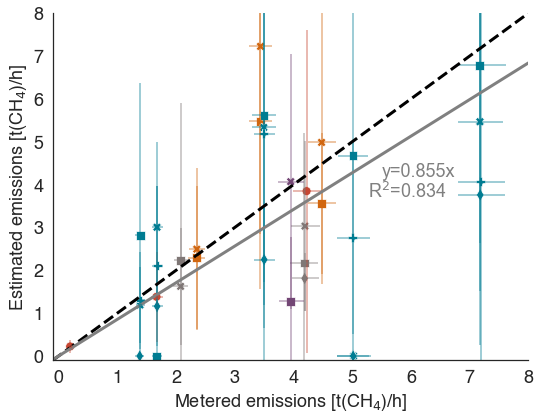

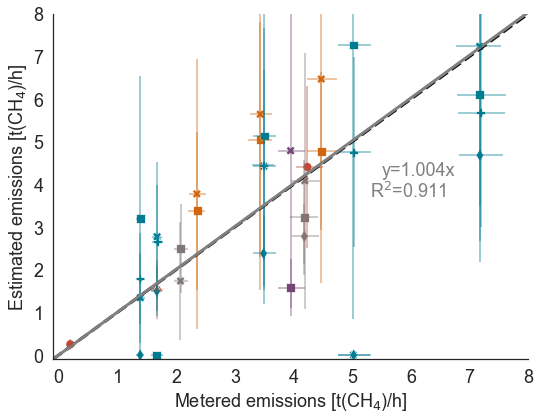

In [279]:
# Plots for stages 1 and 2
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 1 20230118.pdf', satellitedata=satelliteResults, stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 2 20230118.pdf', satellitedata=satelliteResults, stage=2)
# parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 1 95% CI 20230118.pdf', satellitedata=satelliteResults, stage=1)
# parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity stage 2 95% CI 20230118.pdf', satellitedata=satelliteResults, stage=2)

/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/SatelliteTest

<Figure size 432x288 with 0 Axes>

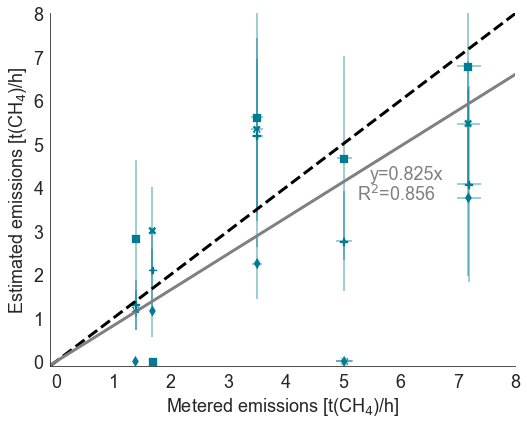

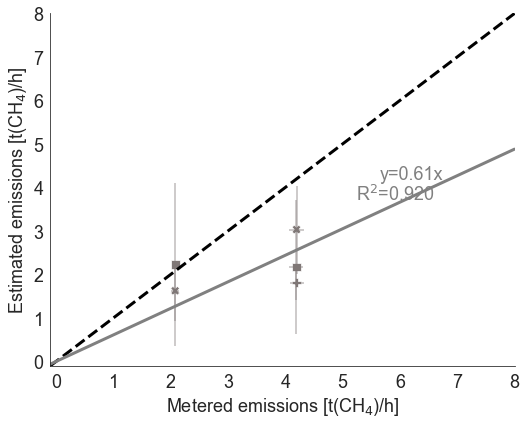

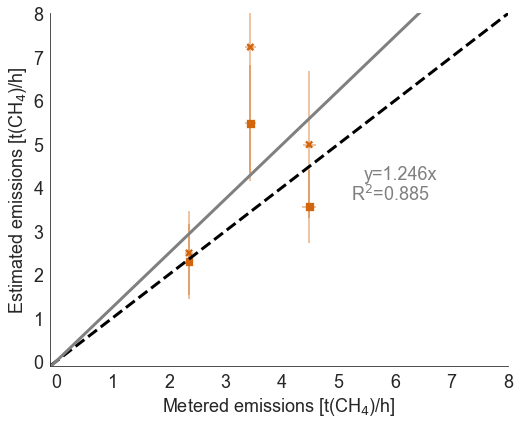

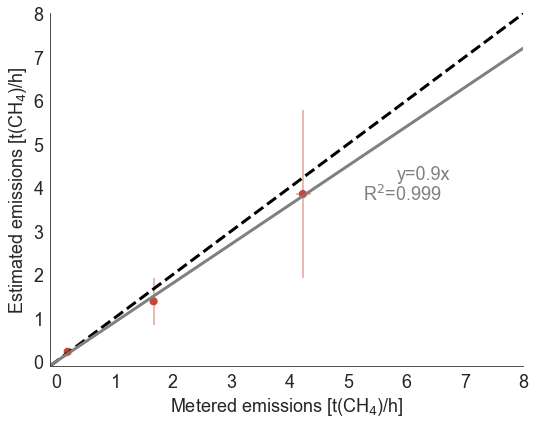

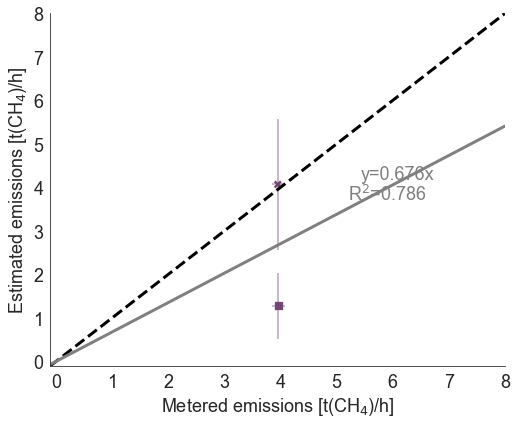

In [202]:
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Sentinel-2 20230116c.pdf', satellitedata=satelliteResults, satellite='Sentinel-2', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Landsat 8 20230116c.pdf', satellitedata=satelliteResults, satellite='Landsat 8', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity PRISMA 20230116c.pdf', satellitedata=satelliteResults, satellite='PRISMA', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity GHGSat C2 20230116c.pdf', satellitedata=satelliteResults, satellite='GHGSat C2', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity WV3 20230116c.pdf', satellitedata=satelliteResults, satellite='WV3', stage=1)

/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))
/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/Users/evansherwin/PycharmProjects/SatelliteTest

<Figure size 432x288 with 0 Axes>

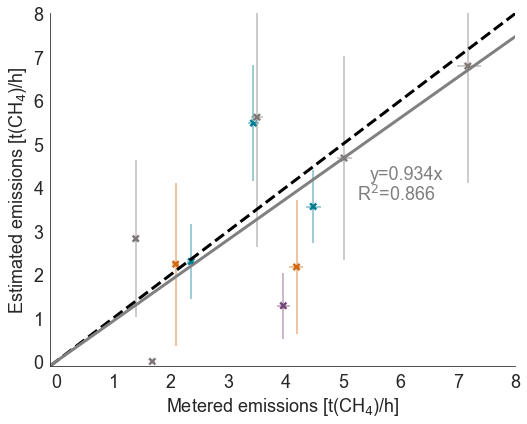

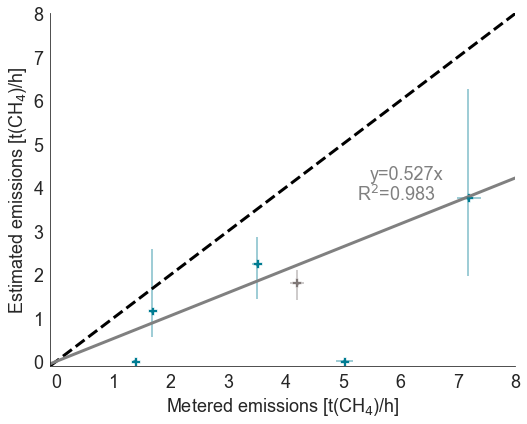

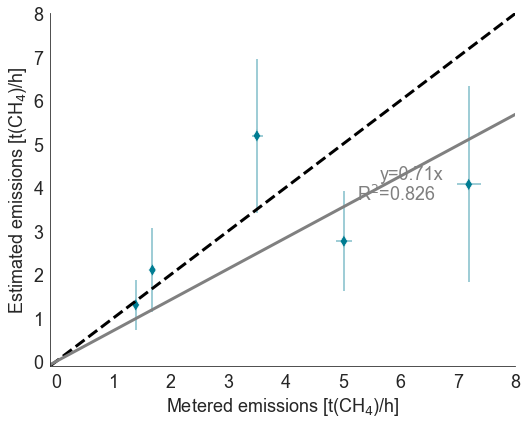

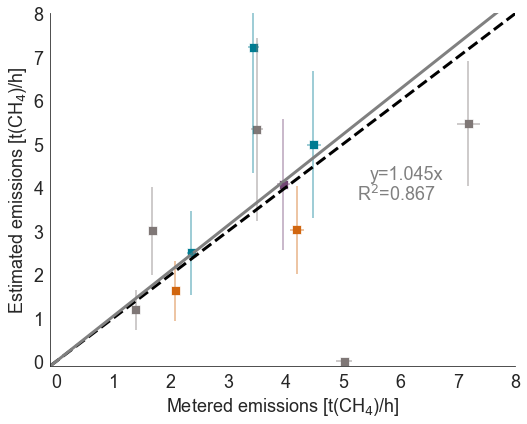

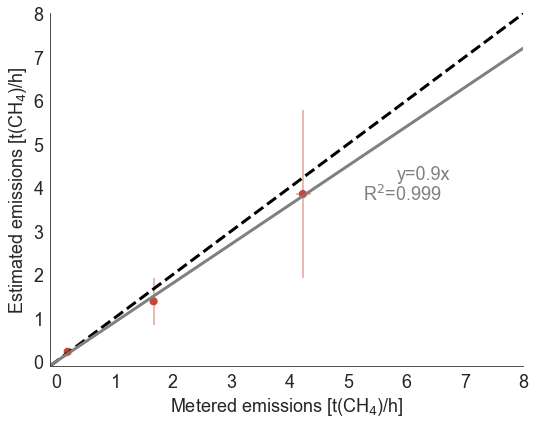

In [221]:
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Kayrros 20230116c.pdf', satellitedata=satelliteResults, team='Kayrros', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity SRON 20230116c.pdf', satellitedata=satelliteResults, team='SRON', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity Harvard 20231016c.pdf', satellitedata=satelliteResults, team='Harvard', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity LARS 20230116c.pdf', satellitedata=satelliteResults, team='LARS', stage=1)
parityPlot(filename='/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity GHGSat 20230116c.pdf', satellitedata=satelliteResults, team='GHGSat', stage=1)

# 'PRISMA' # 'GHGSat C2' # 'Landsat 8' 'Sentinel-2' 'WV3'
    # selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
    # selectedTeam =  'Kayrros'# 'SRON' # 'Harvard' # 'LARS'# 'GHGSat'# 'Kayrros'

In [20]:
slctColorsForErrorbars

array(['#C74632', '#7F7776', '#D1660F', '#007C92', '#734675'], dtype='<U7')

In [55]:
results_main

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1246.7001,559.246,2.229,0.033,104.567,2388.834
x,0.5770,0.140,4.109,0.000,0.290,0.864


In [24]:
# 95% confidence interval for the linear fit
coeffp95 = results_coeff + 1.96*results_main['std err']
coeffp05 = results_coeff - 1.96*results_main['std err']
coeffp05, coeffp95

(x    0.71976
 Name: std err, dtype: float64,
 x    0.99024
 Name: std err, dtype: float64)

In [40]:
# Regression summary
result.summary()
# results_main

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              315.4
Date:                Fri, 10 Jun 2022   Prob (F-statistic):                    8.39e-18
Time:                        07:50:30   Log-Likelihood:                         -273.68
No. Observations:                  32   AIC:                                      549.4
Df Residuals:                      31   BIC:                                      550.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.0043      0.057     17.761      0.000       0.889       1.120
==============================================================================
Omnibus:                        1.104   Durbin-Watson:                   1.241
Prob(Omnibus):                  0.576   Jarque-Bera (JB):                1.059
Skew:                          -0.394   Prob(JB):                        0.589
Kurtosis:                       2.582   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Regression R2 and more summary
result.summary().tables[1]
# results_r2_and_more




NameError: name 'result' is not defined

<AxesSubplot:>

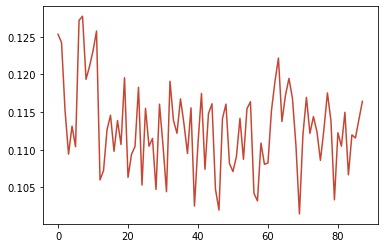

In [43]:
# Max % error in metered emission rate
# satelliteResults
((satelliteResults['cr_kgh_CH4_upper300'] - satelliteResults['cr_kgh_CH4_lower300'])/satelliteResults['cr_kgh_CH4_mean300']).describe()
# max(abs(((satelliteResults['x95pctCIUpper'] - satelliteResults['x95pctCILower'])/satelliteResults['cr_kgh_CH4_mean300'])))
# satelliteResults[['x95pctCIUpper','x95pctCILower']]

In [45]:
# Max % error in
satelliteResults['Error num'].describe()

3

In [53]:
# Error statistics by team
unblindingStage = 2 # 1 # 2
# Select satellite results for the correct unblinding stage, excluding non-detects
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100)]
# x='cr_kgh_CH4_mean300', y='Estimate (KGH) num' 'Error num'
selectedSatelliteResults.groupby('Team')['Error num'].agg(['count', 'min', 'mean', 'max', 'std'])

,count,min,mean,max,std
Team,,,,,
GHGSat,3,-8.209268,7.946916,27.998210,18.415327
Harvard,5,-20.891947,17.670868,58.272634,31.159059
Kayrros,10,-60.065091,24.175877,130.784948,51.991917
SRON,4,-34.762921,-27.599653,-10.278976,11.611290
UPV,10,-16.364877,26.181968,65.477440,31.105193


In [51]:
# Error statistics by satellite
selectedSatelliteResults.groupby('Satellite')['Error num'].agg(['count', 'min', 'mean', 'max', 'std'])


,count,min,mean,max,std
Satellite,,,,,
GHGSat C2,3,-8.209268,7.946916,27.998210,18.415327
Landsat 8,5,-33.561941,-11.055090,19.878627,20.607909
PRISMA,6,6.854812,44.498127,64.470808,20.414444
Sentinel-2,16,-34.762921,19.288769,130.784948,43.470432
WV3,2,-60.065091,-19.399713,21.265665,57.509529


<Figure size 432x360 with 0 Axes>

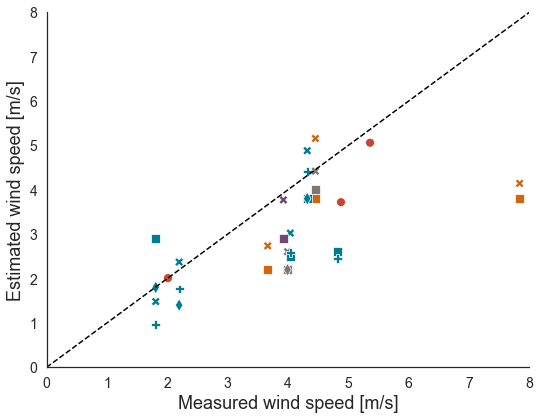

In [293]:
# Wind speed parity chart

fig = plt.gcf()
#fig.set_size_inches(100, 8)

slctMarkers = markers.tolist()
slctColors = colors[[4, 1, 2, 0, 3]] # [[0, 3, 1, 2, 4]]
selectedSatelliteResults = satelliteResults

unblindingStage = 1 # 1 # 2
# selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
StanfordPalette = sns.set_palette(sns.color_palette(slctColors))
# slctMarkers = markers[teamPos].tolist()

mainScatterPlot = sns.relplot(data=selectedSatelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100)], x='Wind_MPS_mean60', y='Wind speed est num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05)

lims = [0, 8]
plt.plot(lims, lims, '--', color='black')
sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.14, 0.99))

plt.xlim(lims[0],lims[1]) #10000
plt.ylim(lims[0],lims[1]) #10000
mainScatterPlot._legend.remove()
# plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0)#, title_fontsize= 'large')
# mainScatterPlot._legend.set_frame_on(True)

plt.xlabel('Measured wind speed [m/s]', fontsize=18)
plt.ylabel('Estimated wind speed [m/s]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams["figure.figsize"] = (6,5)

sns.set_style("white") # "whitegrid
plt.tight_layout()
plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite wind parity 20230118.pdf', format='pdf')
plt.show()

In [83]:
nonzeroRetrievals = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].shape[0]
nonzeroWithinCI = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].shape[0]
nonzeroWithinCI/nonzeroRetrievals
# nonzeroWithinCI
# nonzeroRetrievals

0.90625

In [84]:
nonzeroRetrievalsBySatelliteTeam = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('OperatorSet').size()
nonzeroWithinCIBySatelliteTeam = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('OperatorSet').size()
nonzeroWithinCIBySatelliteTeam/nonzeroRetrievalsBySatelliteTeam
# nonzeroWithinCI
# nonzeroRetrievalsBySatellite

OperatorSet
GHGSat C2/GHGSat      1.000000
Landsat 8/Kayrros     1.000000
Landsat 8/SRON             NaN
Landsat 8/UPV         1.000000
PRISMA/Kayrros        1.000000
PRISMA/UPV            1.000000
Sentinel-2/Harvard    1.000000
Sentinel-2/Kayrros    1.000000
Sentinel-2/SRON       0.666667
Sentinel-2/UPV        1.000000
WV3/Kayrros                NaN
WV3/UPV               1.000000
dtype: float64

In [225]:
nonzeroRetrievalsBySatellite = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('Satellite').size()
nonzeroWithinCIBySatellite = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('Satellite').size()
nonzeroWithinCIBySatellite/nonzeroRetrievalsBySatellite

Satellite
GHGSat C2     1.000000
Landsat 8     0.400000
PRISMA        0.250000
Sentinel-2    0.533333
WV3           0.500000
dtype: float64

In [10]:
np.array([np.abs(selectedData['Estimate (kgh) P2_5'] - selectedData['Estimate (kgh) mean']),
          np.abs(selectedData['Estimate (kgh) P97_5'] - selectedData['Estimate (kgh) mean'])])
# np.array([selectedData['Estimate (kgh) mean']*0.1, selectedData['Estimate (kgh) mean']*0.5]).shape

KeyError: 'Estimate (kgh) P2_5'

In [280]:
selectedData = satelliteResults.loc[(satelliteResults['Satellite'] == 'Sentinel-2')]
slctMeteredErrorbars = selectedData[['Estimate (kgh) P2_5', 'Estimate (kgh) P97_5']].sub(selectedData['Estimate (kgh) mean'], axis='index')
np.concatenate(np.array(slctMeteredErrorbars)).reshape(len(slctMeteredErrorbars), 2).transpose()

KeyError: "None of [Index(['Estimate (kgh) P2_5', 'Estimate (kgh) P97_5'], dtype='object')] are in the [columns]"

In [16]:
# Quantification accuracy for the smallest Sentinel-2 release
satelliteResults.loc[(satelliteResults['Stanford_timestamp'] == '2021-11-03 18:25:01+00:00') & (satelliteResults['UnblindingStage'] == 1), 'Error num']

76    -14.080435
77    103.445597
78     -6.299117
79   -100.000000
Name: Error num, dtype: float64

<Figure size 432x360 with 0 Axes>

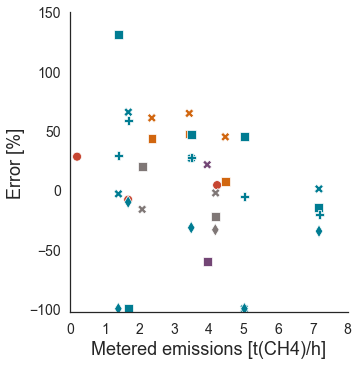

In [288]:
fig = plt.gcf()

unblindingStage = 1 # 2
slctMarkers = markers.tolist()
slctColors = colors[[4, 1, 2, 0, 3]] # [[0, 3, 1, 2, 4]]
selectedSatelliteResults = satelliteResults

sns.set_palette(sns.color_palette(slctColors)) # colors
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
# Percent change
pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Error num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter') #, legend=False)
# In situ wind
# pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Error in situ wind num', style='Team', hue='Satellite', s=80, kind='scatter') #, legend=False)
# sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.8, 0.99))
sns.set_style("white")
plt.xlim(0,8)
plt.ylim(-103,150)
pctScatterPlot._legend.set_title("Satellite")
# mainScatterPlot._legend.draw_frame(True)
pctScatterPlot._legend.set_frame_on(True)
pctScatterPlot._legend.remove()
plt.xlabel('Metered emissions [t(CH4)/h]', fontsize=18)
plt.ylabel('Error [%]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams["figure.figsize"] = (6,5)
# ax.get_yaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.get_xaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))# sns.set_style('darkgrid', {'legend.frameon':True})
plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity error stage 1 20230118.pdf', format='pdf')
# plt.savefig('/Users/evansherwin/PycharmProjects/SatelliteTesting/Figures/Satellite parity error stage 2 20230118.pdf', format='pdf')
# plt.show()

Detection results

In [31]:
# Detection outcomes by satellite/team combination
unblindingStage = 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]

# Fraction detected
totalPointsByTeamSat = selectedSatelliteResults.groupby('OperatorSet').size()
detectionAccuracy = pd.DataFrame(totalPointsByTeamSat, columns=['Total'])
detectionAccuracy['True positive'] =  selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'TP'].groupby('OperatorSet').size()
detectionAccuracy['False negative'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'FN'].groupby('OperatorSet').size()
detectionAccuracy['True negative'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'TN'].groupby('OperatorSet').size()
detectionAccuracy['False positive'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'FP'].groupby('OperatorSet').size()
detectionAccuracy['Filtered retrieval'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'FR'].groupby('OperatorSet').size()
detectionAccuracy['No measurement'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'NT'].groupby('OperatorSet').size()
detectionAccuracy.head()

,Total,True positive,False negative,True negative,False positive,Filtered retrieval,No measurement
OperatorSet,,,,,,,
GHGSat C2/GHGSat,5,3,NaN,NaN,NaN,NaN,2.0
Landsat 8/Kayrros,2,2,NaN,NaN,NaN,NaN,NaN
Landsat 8/LARS,2,2,NaN,NaN,NaN,NaN,NaN
Landsat 8/SRON,2,1,NaN,NaN,NaN,1.0,NaN
PRISMA/Kayrros,4,3,NaN,NaN,NaN,NaN,1.0


In [32]:
# Detection outcomes across all satellites

(Total                 49.0
 True positive         32.0
 False negative         4.0
 True negative          3.0
 False positive         0.0
 Filtered retrieval     6.0
 No measurement         4.0
 dtype: float64,
 Total                 1.000000
 True positive         0.653061
 False negative        0.081633
 True negative         0.061224
 False positive        0.000000
 Filtered retrieval    0.122449
 No measurement        0.081633
 dtype: float64)

In [36]:
# Total estimates reported by all teams across all satellites
detectionAccuracyAllTeams = np.sum(detectionAccuracy)
detectionAccuracyAllTeams, detectionAccuracyAllTeams/detectionAccuracyAllTeams[0]


(Total                 49.0
 True positive         32.0
 False negative         4.0
 True negative          3.0
 False positive         0.0
 Filtered retrieval     6.0
 No measurement         4.0
 dtype: float64,
 Total                 1.000000
 True positive         0.653061
 False negative        0.081633
 True negative         0.061224
 False positive        0.000000
 Filtered retrieval    0.122449
 No measurement        0.081633
 dtype: float64)

In [34]:
# Convert above counts in to a fraction of total measurements for each team and satellite

detectionFraction = 100*pd.DataFrame(detectionAccuracy.drop(columns='Total').div(detectionAccuracy['Total'], axis='rows'))
detectionFraction[np.isnan(detectionFraction)] = 0
detectionFraction

,True positive,False negative,True negative,False positive,Filtered retrieval,No measurement
OperatorSet,,,,,,
GHGSat C2/GHGSat,60.000000,0.000000,0.000000,0.0,0.000000,40.0
Landsat 8/Kayrros,100.000000,0.000000,0.000000,0.0,0.000000,0.0
Landsat 8/LARS,100.000000,0.000000,0.000000,0.0,0.000000,0.0
Landsat 8/SRON,50.000000,0.000000,0.000000,0.0,50.000000,0.0
PRISMA/Kayrros,75.000000,0.000000,0.000000,0.0,0.000000,25.0
PRISMA/LARS,75.000000,0.000000,0.000000,0.0,0.000000,25.0
Sentinel-2/Harvard,71.428571,0.000000,14.285714,0.0,14.285714,0.0
Sentinel-2/Kayrros,57.142857,14.285714,14.285714,0.0,14.285714,0.0
Sentinel-2/LARS,57.142857,14.285714,14.285714,0.0,14.285714,0.0


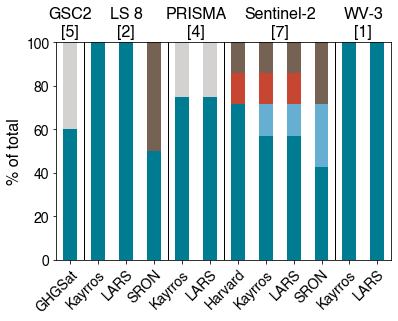

In [35]:
# Matplotlib version of detection plot
# Colors: https://identity.stanford.edu/design-elements/color/accent-colors/
# ['#007C92', '#67AFD2', '#C74632', '#F4795B', '#766253', '#D4D1D1']

fig, ax = plt.subplots()
#plt.font_manager._rebuild()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Helvetica'})
# rc('font',**{'family':'serif','serif':['Helvetica']})
bar1 = ax.bar(detectionFraction.index, detectionFraction['True positive'], width=0.5, ec='None', color='#007C92')
bar2 = ax.bar(detectionFraction.index, detectionFraction['False negative'], bottom=detectionFraction['True positive'], ec='None', width=0.5, color='#67AFD2')
bar3 = ax.bar(detectionFraction.index, detectionFraction['True negative'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'], ec='None', width=0.5, color='#C74632')
bar4 = ax.bar(detectionFraction.index, detectionFraction['False positive'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'], ec='None', width=0.5, color='#F4795B')
bar5 = ax.bar(detectionFraction.index, detectionFraction['Filtered retrieval'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'], ec='None', width=0.5, color='#766253')
bar6 = ax.bar(detectionFraction.index, detectionFraction['No measurement'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'] + detectionFraction['Filtered retrieval'], ec='None', width=0.5, color='#D4D1D1')
# for jj in np.arange(0, detectionAccuracy.iloc[:,0].size):
#     ax.text(jj-0.14, 100.6, detectionAccuracy.iloc[jj,0], fontsize=16, color='black', rotation='horizontal') # kgh
plt.ylabel('% of total', size=16)
# plt.xlabel('Team', size=16)
plt.xticks(np.arange(0, detectionAccuracy.iloc[:,0].size, 1), fontsize=14, rotation=90)
ax.set_xticklabels(['GHGSat', 'Kayrros', 'LARS', 'SRON', 'Kayrros', 'LARS', 'Harvard', 'Kayrros', 'LARS', 'SRON', 'Kayrros', 'LARS'], rotation=45, rotation_mode='anchor', ha='right')
plt.text(0, 103, 'GSC2\n[5]', fontsize=16, color='black', rotation=0, ha='center') # -63
plt.text(2, 103, 'LS 8\n[2]', fontsize=16, color='black', rotation=0, ha='center') # -70
plt.text(4.5, 103, 'PRISMA\n[4]', fontsize=16, color='black', rotation=0, ha='center') # -64
plt.text(7.5, 103, 'Sentinel-2\n[7]', fontsize=16, color='black', rotation=0, ha='center') # -68
plt.text(10.5, 103, 'WV-3\n[1]', fontsize=16, color='black', rotation=0, ha='center') # -55
plt.axvline(0.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(3.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(5.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(9.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.yticks(np.arange(0, 101, 20), fontsize=14)
plt.ylim(0,100) # 107
plt.xlim(-0.5,11.5)
# plt.text(11+0.6, 100.4, '# Total', fontsize=18, color='black', rotation='horizontal') # kgh
# plt.text(-3, -20, 'Team', fontsize=20, color='black', rotation=0) # -55
# ax.legend(labels=detectionFraction.columns) # , handles=[bar1, bar2, bar3, bar4, bar5, bar6]
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
# plt.rcParams['text.usetex'] = True # http://phyletica.org/matplotlib-fonts/
# plt.rcParams['ps.fonttype'] = 42
plt.savefig('Detections 20230125.pdf', format='pdf', bbox_inches="tight")
# plt.show()

Metered emission rate, wind speed, and wind direction for emissions from Figure 2

In [47]:
key_fig2_cols = ["cr_kgh_CH4_mean300", "Wind_MPS_mean60", "Wind_MPS_sd60", "Wind_dir_mean60", "Wind_dir_sd60"]
Figure2_vals = pd.DataFrame(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-27 18:34:57+00:00") & (selectedSatelliteResults["OperatorSet"]=="Sentinel-2/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-21 18:10:37+00:00") & (selectedSatelliteResults["OperatorSet"]=="Landsat 8/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-21 18:23:12+00:00") & (selectedSatelliteResults["OperatorSet"]=="PRISMA/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-23 18:40:53+00:00") & (selectedSatelliteResults["OperatorSet"]=="WV3/Kayrros"), key_fig2_cols])
Figure2_vals = Figure2_vals.append(selectedSatelliteResults.loc[(selectedSatelliteResults["Stanford_timestamp"]=="2021-10-24 17:35:19+00:00") & (selectedSatelliteResults["OperatorSet"]=="GHGSat C2/GHGSat"), key_fig2_cols])
Figure2_vals.index = ["Sentinel-2", "Landsat 8", "PRISMA", "WorldView 3", "GHGSat C2"]
np.round(Figure2_vals, 1)

,cr_kgh_CH4_mean300,Wind_MPS_mean60,Wind_MPS_sd60,Wind_dir_mean60,Wind_dir_sd60
Sentinel-2,3.5,4.3,0.7,57.0,15.4
Landsat 8,4.2,4.0,0.9,48.8,7.8
PRISMA,4.5,3.7,0.7,38.9,5.2
WorldView 3,4.0,3.9,0.7,243.0,10.4
GHGSat C2,4.2,2.0,0.4,264.1,10.8


In [43]:
# Error statistics, percent of detected emissions with Stage 1 absolute error below 50%
satelliteResults.loc[satelliteResults['Error num'] > -100, 'Error num'].describe()
detectedResults = satelliteResults.loc[satelliteResults['Error num'] > -100, 'Error num'].size
detectedResultsUnder50 = (abs(satelliteResults.loc[satelliteResults['Error num'] > -100, 'Error num']) < 50).sum()
detectedResultsUnder50, detectedResults, detectedResultsUnder50/detectedResults

(50, 64, 0.78125)

In [51]:
# Quantification error statistics by averaging period (in seconds)
unblindingStage = 1 # 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
satelliteResults['Error num 60'] = (satelliteResults['Estimate (KGH) num']*kg_per_t - satelliteResults['cr_kgh_CH4_mean60'])*100/satelliteResults['cr_kgh_CH4_mean60']
satelliteResults['Error num 600'] = (satelliteResults['Estimate (KGH) num']*kg_per_t - satelliteResults['cr_kgh_CH4_mean600'])*100/satelliteResults['cr_kgh_CH4_mean600']
selectedSatelliteErr = (satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), ['Error num', 'Error num 60', 'Error num 600']])
selectedSatelliteErr.columns = ['Error num 300', 'Error num 60', 'Error num 600']
selectedSatelliteErr.describe()
# satelliteResults.loc[satelliteResults['Error num'] > -100, 'Error num'].describe()

,Error num 300,Error num 60,Error num 600
count,32.000000,32.000000,32.000000
mean,1.559186,1.535675,2.043903
std,45.370588,45.878814,44.913125
min,-67.603800,-67.469260,-68.111443
25%,-28.515522,-27.909010,-29.020234
50%,-6.525853,-7.834774,-5.659249
75%,16.072128,16.617495,17.377628
max,110.167867,113.263117,108.180112


In [52]:
# Number of errors between ±50%
np.mean(np.abs(selectedSatelliteErr) < 50)

Error num 300    0.75000
Error num 60     0.75000
Error num 600    0.71875
dtype: float64

In [133]:
# Kairos controlled releases with error less than ±50%
# Downloaded from https://github.com/yuliachen/Single-blind-test-of-airplane-based-hyperspectral-methane-detection-via-controlled-releases/blob/master/github_version/Stanford_Kairos_controlled_release_2019_studyData.xlsx
# From Sherwin, Chen et al. 2021
kairos_CR_data = pd.read_excel('/Users/evansherwin/PycharmProjects/SatelliteTesting/Data/Stanford_Kairos_controlled_release_2019_studyData.xlsx', sheet_name="DATA", engine = 'openpyxl', skiprows=1 )
molCH4_per_mol_NG = 0.935 # Sherwin, Chen et al. 2021
kairos_estimate_mcfd_mph_CH4 = kairos_CR_data['closest_plume_quantification_mcfdmph']
metered_estimate_mcfd_mph_CH4 = kairos_CR_data['total_release_mcfd']*molCH4_per_mol_NG/kairos_CR_data['WS_windGust_logged_mph']
kairos_estimate_pct_err =  100*(kairos_estimate_mcfd_mph_CH4 - metered_estimate_mcfd_mph_CH4)/metered_estimate_mcfd_mph_CH4
# Exclude non-detects
kairos_quantified_pct_err = kairos_estimate_pct_err[np.isnan(kairos_estimate_pct_err)==False]
# Number of errors between ±50%
np.mean(np.abs(kairos_quantified_pct_err) <= 50)

0.868421052631579

In [ ]:
# Fraction estimates with CI overlapping parity line
CI_overlapping_parity = satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'within CI']==True
np.sum(CI_overlapping_parity)/CI_overlapping_parity.size

In [ ]:
# % difference from stage 1 to stage 2
stage1Ests = np.array(satelliteResults.loc[(satelliteResults['UnblindingStage']==1), 'Estimate (KGH) num'])
stage2Ests = np.array(satelliteResults.loc[(satelliteResults['UnblindingStage']==2), 'Estimate (KGH) num'])
pctChange = (stage2Ests - stage1Ests)/stage1Ests
np.nanmean(pctChange), np.nanmedian(pctChange)
# stage2Ests

In [58]:
# Wind error statistics
unblindingStage = 1 # 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
selectedWindErrPct = 100*(satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage)  & (satelliteResults['Error num'] > -100),'Wind speed est num'] - satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'Wind_MPS_mean60'])/\
                     satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'Wind_MPS_mean60']
selectedWindErrPct.describe()
# selectedWindErrPct

count     32.000000
mean     -21.520902
std       28.420126
min     -100.000000
25%      -41.190844
50%      -21.697465
75%       -3.102648
max       60.353884
dtype: float64

In [95]:
# Linear regression for Stage 1 satellite data, forced zero intercept, excluding non-detects
unblindingStage = 1 # 2
floorQuantificationEstimate = 0 # Exclude all emissions less than or equal to this from the regression analysis
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
include_intercept=False # True False
X = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > floorQuantificationEstimate), 'cr_kgh_CH4_mean300']).reshape(-1,1)
y = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > floorQuantificationEstimate), 'Estimate (KGH) num']).reshape(-1,1)
reg_stage1 = sm.OLS(y, X).fit()
reg_stage1.summary()
# reg_stage1 = LinearRegression(fit_intercept=include_intercept).fit(X, y)
# reg_stage1.coef_, reg_stage1.intercept_, reg_stage1.score(X, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.834
Model:                            OLS   Adj. R-squared (uncentered):              0.829
Method:                 Least Squares   F-statistic:                              155.6
Date:                Thu, 26 Jan 2023   Prob (F-statistic):                    1.28e-13
Time:                        18:05:06   Log-Likelihood:                         -58.804
No. Observations:                  32   AIC:                                      119.6
Df Residuals:                      31   BIC:                                      121.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8550      0.069     12.474      0.000       0.715       0.995
==============================================================================
Omnibus:                        1.764   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.414   Jarque-Bera (JB):                1.011
Skew:                           0.428   Prob(JB):                        0.603
Kurtosis:                       3.157   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
# Linear regression results for Stage 1 satellite data, floating intercept, excluding non-detects
reg_float_intercept = LinearRegression(fit_intercept=True).fit(X, y)
reg_float_intercept.coef_, reg_float_intercept.intercept_, reg_float_intercept.score(X, y)

(array([[0.57701666]]), array([1.2467001]), 0.36017235327640684)

In [96]:
# Linear regression for Stage 2 satellite data, forced zero intercept, excluding non-detects
unblindingStage = 2
floorQuantificationEstimate = 0 # Exclude all emissions less than or equal to this from the regression analysis
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
include_intercept=False # True False
X = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > floorQuantificationEstimate), 'cr_kgh_CH4_mean300']).reshape(-1,1)
y = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > floorQuantificationEstimate), 'Estimate (KGH) num']).reshape(-1,1)
reg_stage2 = sm.OLS(y, X).fit()
reg_stage2.summary()
# reg_stage2 = LinearRegression(fit_intercept=include_intercept).fit(X, y)
# reg_stage2.coef_, reg_stage2.intercept_, reg_stage2.score(X, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              315.4
Date:                Thu, 26 Jan 2023   Prob (F-statistic):                    8.39e-18
Time:                        18:05:09   Log-Likelihood:                         -52.636
No. Observations:                  32   AIC:                                      107.3
Df Residuals:                      31   BIC:                                      108.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0043      0.057     17.761      0.000       0.889       1.120
==============================================================================
Omnibus:                        1.104   Durbin-Watson:                   1.241
Prob(Omnibus):                  0.576   Jarque-Bera (JB):                1.059
Skew:                          -0.394   Prob(JB):                        0.589
Kurtosis:                       2.582   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
reg_stage2.get_params

AttributeError: 'function' object has no attribute 'describe'

In [ ]:
pearson_corr, _ = stats.pearsonr((reg.coef_*X + reg.intercept_).flatten(), y.flatten())
pearson_corr
# reg = sm.OLS(fit_intercept=include_intercept).fit(X, y)
# reg.bse
# .reshape(-1,1)
# n,pearson_corr,slope,intercept,r_value,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0), 'cr_kgh_CH4_mean300'], selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0), 'Estimate (KGH) num'])
# slope,intercept,r_value



In [ ]:
# Linear regression for satellite data, forced zero intercept
include_intercept=True # True
force_intercept=include_intercept==False
n,slope,intercept,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual = odr_results(X.flatten(), y.flatten(), force_intercept_origin=force_intercept)
# n,slope,intercept,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual
slope, intercept

In [ ]:
# ODR Pearson correlation
pearson_corrODR, _ = stats.pearsonr((slope*X + intercept).flatten(), y.flatten())
pearson_corrODR

In [54]:
# satelliteResults[['OperatorSet', 'Wind speed est num', 'Wind_MPS_mean30', 'Wind_MPS_mean60', 'Wind_MPS_mean300']]

,OperatorSet,Wind speed est num,Wind_MPS_mean30,Wind_MPS_mean60,Wind_MPS_mean300
0,GHGSat C2/GHGSat,3.720000,4.886000,4.877500,4.329133
1,GHGSat C2/GHGSat,4.270000,4.886000,4.877500,4.329133
2,GHGSat C2/GHGSat,2.010000,1.713333,2.011667,2.641100
3,GHGSat C2/GHGSat,2.490000,1.713333,2.011667,2.641100
4,GHGSat C2/GHGSat,5.060000,5.641667,5.359500,4.816333
...,...,...,...,...,...
93,Sentinel-2/SRON,0.000000,4.524667,4.038333,3.690500
94,WV3/LARS,3.771273,4.337667,3.923500,4.182300
95,WV3/Kayrros,2.900000,4.337667,3.923500,4.182300
96,WV3/LARS,4.673417,4.337667,3.923500,4.182300


In [55]:
# GHGSat errors
selectedSatelliteErrGHGSat = (satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100) & (satelliteResults['Team'] == 'GHGSat'), 'Error num'])
selectedSatelliteErrGHGSat


0   -17.140810
2    -8.889579
4    12.992303
Name: Error num, dtype: float64